<a href="https://colab.research.google.com/github/BlueBerry-Coder/Practice/blob/main/Model3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

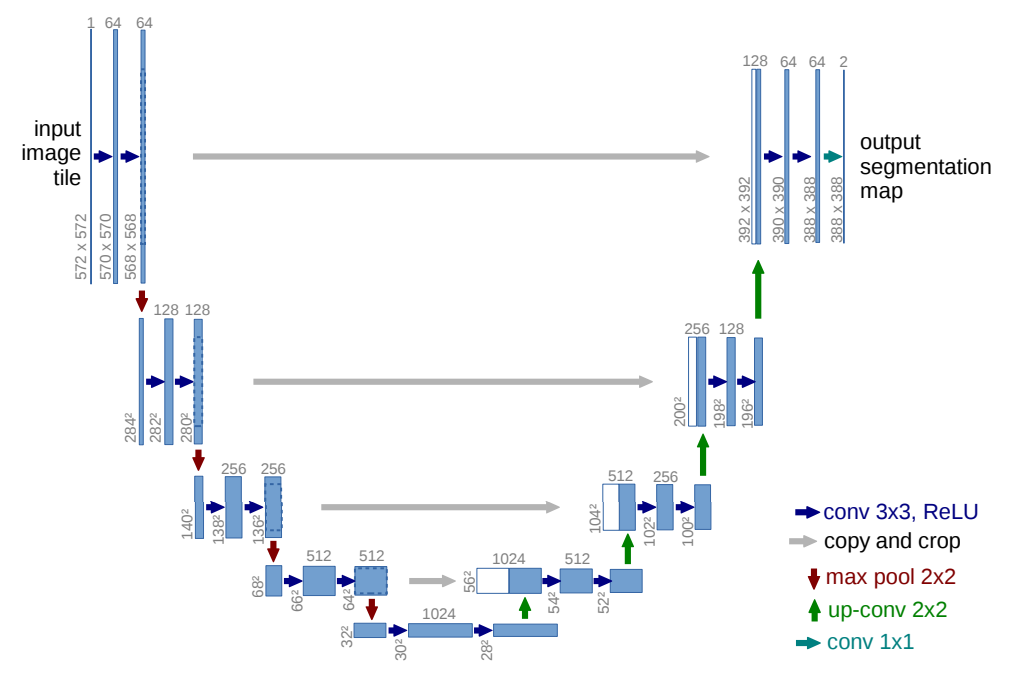

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchsummary import summary

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, (3, 3, 3), (1, 1, 1), (1, 1, 1), bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, (3, 3, 3), (1, 1, 1), (1, 1, 1), bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)

        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNET3D(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[4, 8, 16],
    ):
        super(UNET3D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        # 161 * 161 --> MaxPool --> 80 * 80. output: 160 * 160

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose3d(
                    feature * 2, feature, kernel_size=(2, 2, 2), stride=(2, 2, 2),
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=(1, 1, 1))

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[3:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [ ]:
def test():
    x = torch.randn((1, 1, 240, 240, 155))
    model = UNET3D(in_channels=1, out_channels=1)
    preds = model(x)
    start_time = time.time()
    print("--- %s seconds ---" % (time.time() - start_time))
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [ ]:
if __name__ == "__main__":
    test()

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [120, 120, 76] and output size of [120, 77]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.